# 第十七次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW17-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">5月25日23:59前</span>提交**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

## 请认真阅读代码，理解代码的功能
### 创建变量
pytorch创建变量的语法与numpy有许多相似之处。下面列举了pytorch创建变量的一些常见用法：

In [2]:
import torch
import numpy as np

# 创建一个张量（tensor）
x = torch.tensor([1, 2, 3, 4])
print("x:", x)

# 创建一个矩阵（matrix）
y = torch.tensor([[1, 2], [3, 4]])
print("y:", y)

# 创建一个全零的张量
z = torch.zeros((2, 3))
print("z:", z)

# 创建一个随机初始化的张量
w = torch.randn((3, 3))
print("w:", w)

# pytorch tensor与numpy array的相互转换
numpy_array = np.array([1, 2, 3, 4, 5])

# 将NumPy数组转换为PyTorch张量
torch_tensor = torch.from_numpy(numpy_array)
print(torch_tensor)

# 将PyTorch张量转换为NumPy数组
numpy_array = torch_tensor.numpy()
print(numpy_array)

x: tensor([1, 2, 3, 4])
y: tensor([[1, 2],
        [3, 4]])
z: tensor([[0., 0., 0.],
        [0., 0., 0.]])
w: tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193]])
tensor([1, 2, 3, 4, 5])
[1 2 3 4 5]


### 算术运算

In [3]:
import torch

# 创建一个服从标准正态分布的3*4的张量A
A = torch.randn((3, 4))
print("A:", A)

# 创建一个服从标准正态分布的2*6的张量B
B = torch.randn((2, 6))
print("B:", B)

# 使用view操作将B的形状也转换成3*4，计算A+B和A*B^T（矩阵乘法）
B = B.view(3, 4)
print("A+B:", A + B)
print("A*B^T:", A.matmul(B.t()))

# 取出矩阵A的所有大于0的值，并按照行的顺序排列成一个一维的张量C。
# 例如：[[0, 0.1, 0.2], [-0.3, 0.4, -0.5]]需要转换成[0.1, 0.2, 0.4]
C = A[A > 0]
print("C:", C)

# 将C的每个元素平方，得到D。计算D的平均值mean(D)，并求出mean(D)对A的梯度
D = C ** 2
D = D.clone().detach().requires_grad_(True)  # 需指定requires_grad=True，否则无法求梯度
print("D:", D)
print("mean(D):", D.mean())
D.mean().backward()
print("A.grad:", A.grad)

# 将A中所有大于零的数置为零并输出
A[A > 0] = 0
print("A:", A)

# 使用detach方法将一个张量A从计算图中分离出来，并将其转换为一个不需要梯度的张量B
A = torch.randn((3, 4), requires_grad=True)
B = A.detach()
print("A.requires_grad:", A.requires_grad)
print("B.requires_grad:", B.requires_grad)

# 使用with torch.no_grad()包装一个计算过程，使得其中的计算不会被记录到计算图中
with torch.no_grad():
    C = A + 2
    print("C.requires_grad:", C.requires_grad)
    


A: tensor([[-0.4033, -0.5966,  0.1820, -0.8567],
        [ 1.1006, -1.0712,  0.1227, -0.5663],
        [ 0.3731, -0.8920, -1.5091,  0.3704]])
B: tensor([[ 1.4565,  0.9398,  0.7748,  0.1919,  1.2638, -1.2904],
        [-0.7911, -0.0209, -0.7185,  0.5186, -1.3125,  0.1920]])
A+B: tensor([[ 1.0532,  0.3432,  0.9569, -0.6648],
        [ 2.3644, -2.3616, -0.6684, -0.5872],
        [-0.3454, -0.3734, -2.8216,  0.5624]])
A*B^T: tensor([[-1.1715,  0.1341, -0.4230],
        [ 0.5827,  2.6880, -1.6161],
        [-1.3931,  2.8087,  1.3212]])
C: tensor([0.1820, 1.1006, 0.1227, 0.3731, 0.3704])
D: tensor([0.0331, 1.2113, 0.0151, 0.1392, 0.1372], requires_grad=True)
mean(D): tensor(0.3072, grad_fn=<MeanBackward0>)
A.grad: None
A: tensor([[-0.4033, -0.5966,  0.0000, -0.8567],
        [ 0.0000, -1.0712,  0.0000, -0.5663],
        [ 0.0000, -0.8920, -1.5091,  0.0000]])
A.requires_grad: True
B.requires_grad: False
C.requires_grad: False


## 基于FasionMNIST的图像分类任务

In [4]:
training_data = datasets.FashionMNIST(
    root="./", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(
    root="./", train=False, download=True, transform=ToTensor())

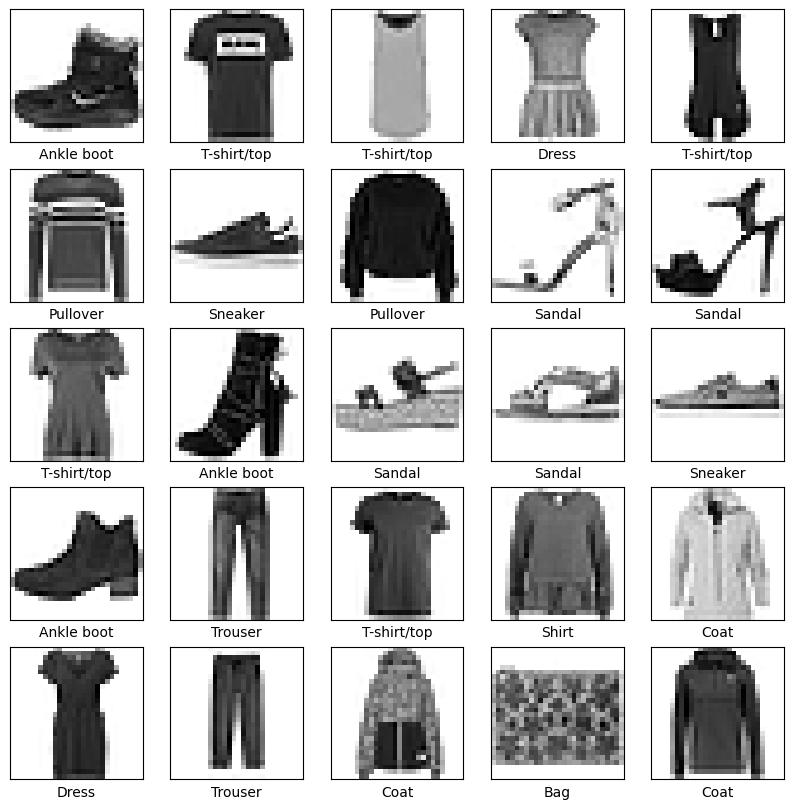

In [5]:
# 进行简单的可视化
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data[i][0].squeeze(0), cmap=plt.cm.binary)
    plt.xlabel(labels[training_data[i][1]])
plt.show()

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

In [7]:
# TODO 数据加载器(1')
train_dataloader = DataLoader(training_data, BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_data, BATCH_SIZE, num_workers=8)

In [8]:
# TODO 按照下图定义模型(2')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


<?xml version="1.0" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="192pt" height="337pt" viewBox="0.00 0.00 192.15 337">
<g id="graph0" class="graph" transform="translate(13.086503072123655,316.16394050517243) scale(0.8420629536084173)" data-name="G">

<polygon fill="white" stroke="none" points="-4,4 -4,-333 188.15,-333 188.15,4 -4,4"/>
<!-- input -->
<g id="node1" class="node" pointer-events="visible" data-name="input">

<polygon fill="none" stroke="black" points="0,-292.5 0,-328.5 184.15,-328.5 184.15,-292.5 0,-292.5"/>
<text text-anchor="middle" x="22.78" y="-306.3" font-family="Times,serif" font-size="14.00">Input</text>
<polyline fill="none" stroke="black" points="45.55,-292.5 45.55,-328.5"/>
<text text-anchor="middle" x="114.85" y="-306.3" font-family="Times,serif" font-size="14.00">(Flatten到28*28=784)</text>
</g>
<!-- fc1 -->
<g id="node2" class="node" pointer-events="visible" data-name="fc1">

<polygon fill="none" stroke="black" points="34.9,-219.5 34.9,-255.5 149.25,-255.5 149.25,-219.5 34.9,-219.5"/>
<text text-anchor="middle" x="92.08" y="-233.4" font-family="Times,serif" font-size="14.00">Linear(784→128)</text>
</g>
<!-- input&#45;&gt;fc1 -->
<g id="edge1" class="edge" data-name="input-&gt;fc1">

<path fill="none" stroke="black" d="M92.08,-292.67C92.08,-284.89 92.08,-275.44 92.08,-266.62"/>
<polygon fill="black" stroke="black" points="95.58,-266.72 92.08,-256.72 88.58,-266.72 95.58,-266.72"/>
</g>
<!-- relu -->
<g id="node3" class="node" pointer-events="visible" data-name="relu">

<polygon fill="none" stroke="black" points="65.08,-146.5 65.08,-182.5 119.08,-182.5 119.08,-146.5 65.08,-146.5"/>
<text text-anchor="middle" x="91.68" y="-160.3" font-family="Times,serif" font-size="14.00">ReLU</text>
</g>
<!-- fc1&#45;&gt;relu -->
<g id="edge2" class="edge" data-name="fc1-&gt;relu">

<path fill="none" stroke="black" d="M92.08,-219.67C92.08,-211.89 92.08,-202.44 92.08,-193.62"/>
<polygon fill="black" stroke="black" points="95.58,-193.72 92.08,-183.72 88.58,-193.72 95.58,-193.72"/>
</g>
<!-- fc2 -->
<g id="node4" class="node" pointer-events="visible" data-name="fc2">

<polygon fill="none" stroke="black" points="38.4,-73.5 38.4,-109.5 145.75,-109.5 145.75,-73.5 38.4,-73.5"/>
<text text-anchor="middle" x="92.08" y="-87.4" font-family="Times,serif" font-size="14.00">Linear(129→10)</text>
</g>
<!-- relu&#45;&gt;fc2 -->
<g id="edge3" class="edge" data-name="relu-&gt;fc2">

<path fill="none" stroke="black" d="M92.08,-146.67C92.08,-138.89 92.08,-129.44 92.08,-120.62"/>
<polygon fill="black" stroke="black" points="95.58,-120.72 92.08,-110.72 88.58,-120.72 95.58,-120.72"/>
</g>
<!-- output -->
<g id="node5" class="node" pointer-events="visible" data-name="output">

<polygon fill="none" stroke="black" points="64.63,-0.5 64.63,-36.5 119.52,-36.5 119.52,-0.5 64.63,-0.5"/>
<text text-anchor="middle" x="92.08" y="-14.3" font-family="Times,serif" font-size="14.00">Output</text>
</g>
<!-- fc2&#45;&gt;output -->
<g id="edge4" class="edge" data-name="fc2-&gt;output">

<path fill="none" stroke="black" d="M92.08,-73.67C92.08,-65.89 92.08,-56.44 92.08,-47.62"/>
<polygon fill="black" stroke="black" points="95.58,-47.72 92.08,-37.72 88.58,-47.72 95.58,-47.72"/>
</g>
</g>
</svg>

In [9]:
# TODO 创建模型，并选择合适的优化器和损失函数(1')
model = Net()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [10]:
# TODO 模型训练过程(2')
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch, (data, target) in enumerate(train_dataloader):
        #***********************************
        # 请在此处添加代码，完成模型训练过程
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        #***********************************
    return train_loss / len(train_dataloader), 100. * correct / total

def test(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch, (data, target) in enumerate(test_dataloader):
            #***********************************
            # 请在此处添加代码，完成模型测试过程
            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            #***********************************
    return test_loss / len(test_dataloader), 100. * correct / total

Epoch 1/10, Train Loss: 0.5458, Train Acc: 81.25%, Test Loss: 0.4659, Test Acc: 83.55%
Epoch 2/10, Train Loss: 0.4046, Train Acc: 85.68%, Test Loss: 0.4273, Test Acc: 84.68%
Epoch 3/10, Train Loss: 0.3632, Train Acc: 87.05%, Test Loss: 0.4384, Test Acc: 84.83%
Epoch 4/10, Train Loss: 0.3357, Train Acc: 87.97%, Test Loss: 0.3692, Test Acc: 86.70%
Epoch 5/10, Train Loss: 0.3153, Train Acc: 88.49%, Test Loss: 0.3729, Test Acc: 86.74%
Epoch 6/10, Train Loss: 0.3017, Train Acc: 89.01%, Test Loss: 0.3692, Test Acc: 86.80%
Epoch 7/10, Train Loss: 0.2878, Train Acc: 89.46%, Test Loss: 0.3641, Test Acc: 87.23%
Epoch 8/10, Train Loss: 0.2766, Train Acc: 89.83%, Test Loss: 0.3492, Test Acc: 87.57%
Epoch 9/10, Train Loss: 0.2677, Train Acc: 90.14%, Test Loss: 0.3499, Test Acc: 87.72%
Epoch 10/10, Train Loss: 0.2581, Train Acc: 90.53%, Test Loss: 0.3426, Test Acc: 87.98%


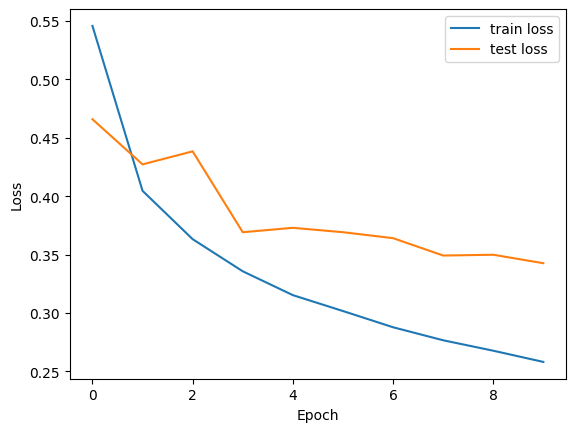

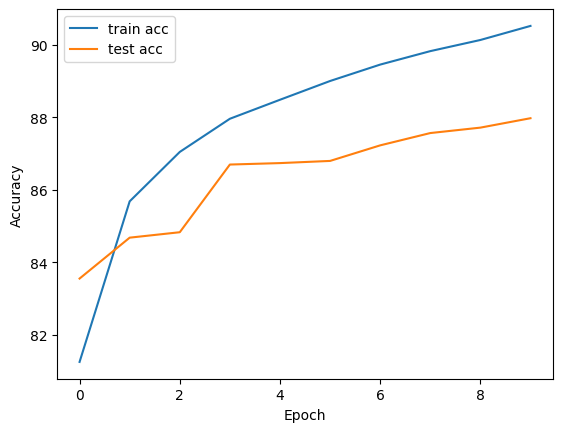

In [11]:
# 训练模型
def train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        test_loss, test_acc = test(model, test_dataloader, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(test_loss_list, label='test loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train acc')
    plt.plot(test_acc_list, label='test acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # 保存模型
    torch.save(model.state_dict(), 'model.pth')

    # 加载模型
    model = Net()
    model.load_state_dict(torch.load('model.pth'))

train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion)

## 模型调优与参数优化（5‘）
### 修改网络结构，**加入卷积层与池化层**。(2')

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CNN()

LEARNING_RATE = 0.001
EPOCHS = 10
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# 训练函数
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch, (data, target) in enumerate(train_dataloader):
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算损失和准确率
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return train_loss / len(train_dataloader), 100. * correct / total

# 测试函数
def test(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch, (data, target) in enumerate(test_dataloader):
            # 前向传播
            output = model(data)
            loss = criterion(output, target)

            # 计算损失和准确率
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return test_loss / len(test_dataloader), 100. * correct / total


Epoch 1/10, Train Loss: 0.4638, Train Acc: 83.11%, Test Loss: 0.3589, Test Acc: 86.99%
Epoch 2/10, Train Loss: 0.2979, Train Acc: 89.19%, Test Loss: 0.3012, Test Acc: 89.27%
Epoch 3/10, Train Loss: 0.2531, Train Acc: 90.67%, Test Loss: 0.2771, Test Acc: 90.04%
Epoch 4/10, Train Loss: 0.2245, Train Acc: 91.74%, Test Loss: 0.2667, Test Acc: 90.41%
Epoch 5/10, Train Loss: 0.1988, Train Acc: 92.68%, Test Loss: 0.2440, Test Acc: 91.13%
Epoch 6/10, Train Loss: 0.1773, Train Acc: 93.48%, Test Loss: 0.2477, Test Acc: 91.21%
Epoch 7/10, Train Loss: 0.1569, Train Acc: 94.12%, Test Loss: 0.2419, Test Acc: 91.33%
Epoch 8/10, Train Loss: 0.1413, Train Acc: 94.69%, Test Loss: 0.2445, Test Acc: 91.64%
Epoch 9/10, Train Loss: 0.1261, Train Acc: 95.28%, Test Loss: 0.2760, Test Acc: 91.04%
Epoch 10/10, Train Loss: 0.1076, Train Acc: 96.02%, Test Loss: 0.2767, Test Acc: 91.06%


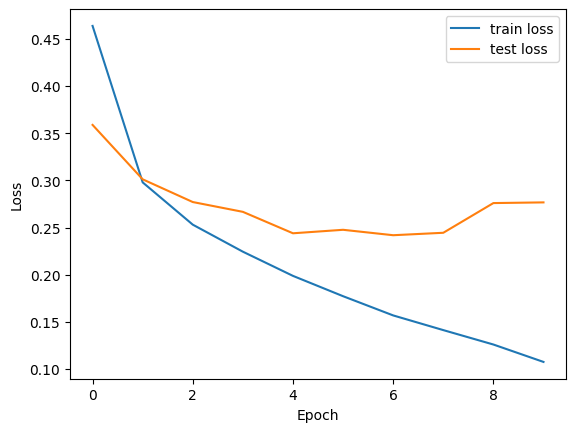

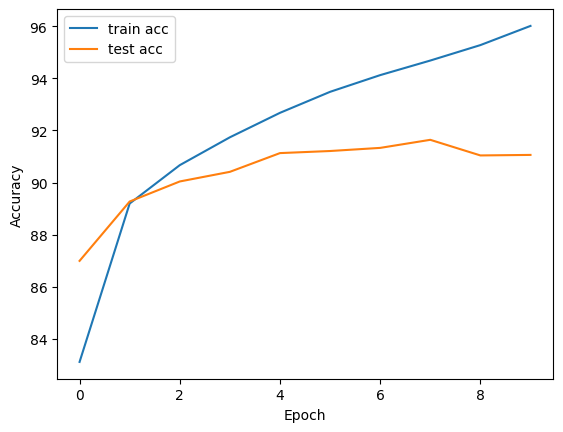

In [13]:
# 训练模型
def train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        test_loss, test_acc = test(model, test_dataloader, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(test_loss_list, label='test loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train acc')
    plt.plot(test_acc_list, label='test acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # 保存模型
    torch.save(model.state_dict(), 'model.pth')

    # 加载模型
    model = CNN()
    model.load_state_dict(torch.load('model.pth'))

train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion)

### 从包括但不限于以下方面对上述模型进行优化，要求至少尝试**两种**不同方面的优化方式，优化你的模型性能(2')
- 数据增强
- 早停策略
- 激活函数调整
- 正则化
- Dropout
- BatchNorm
- 网络结构调整
- 模型集成
- 超参数调优
- 其他技巧


将Alexnet的模型应用在FashionMNIST数据集上产生了不错的效果，在30个epoch下可达到92.41%的准确率。为了对应其227*227的输入，要先进行数据的resize和归一化。在模型的设计上，相比之前加深了层数并且在线性层进行dropout。在进行训练的时候使用 OneCycleLR 调度器，通过动态调整学习率来加快收敛速度和提高最终性能。同时由于模型较为复杂，移到gpu上进行训练。具体的模型参数在输出中。

ImprovedCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_featur

/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/35, Train Loss: 0.9960, Train Acc: 63.84%, Test Loss: 0.6288, Test Acc: 75.42%
Best Acc:75.42
Epoch 2/35, Train Loss: 0.5263, Train Acc: 80.12%, Test Loss: 0.4731, Test Acc: 82.76%
Best Acc:82.76
Epoch 3/35, Train Loss: 0.4149, Train Acc: 84.68%, Test Loss: 0.3913, Test Acc: 85.51%
Best Acc:85.51
Epoch 4/35, Train Loss: 0.3550, Train Acc: 86.94%, Test Loss: 0.3523, Test Acc: 87.16%
Best Acc:87.16
Epoch 5/35, Train Loss: 0.3241, Train Acc: 88.08%, Test Loss: 0.3290, Test Acc: 88.07%
Best Acc:88.07
Epoch 6/35, Train Loss: 0.3010, Train Acc: 88.99%, Test Loss: 0.3158, Test Acc: 88.54%
Best Acc:88.54
Epoch 7/35, Train Loss: 0.2803, Train Acc: 89.63%, Test Loss: 0.3025, Test Acc: 88.59%
Best Acc:88.59
Epoch 8/35, Train Loss: 0.2660, Train Acc: 90.20%, Test Loss: 0.2901, Test Acc: 89.43%
Best Acc:89.43
Epoch 9/35, Train Loss: 0.2527, Train Acc: 90.73%, Test Loss: 0.2909, Test Acc: 88.79%
Epoch 10/35, Train Loss: 0.2439, Train Acc: 90.91%, Test Loss: 0.2712, Test Acc: 90.13%
Best Acc:

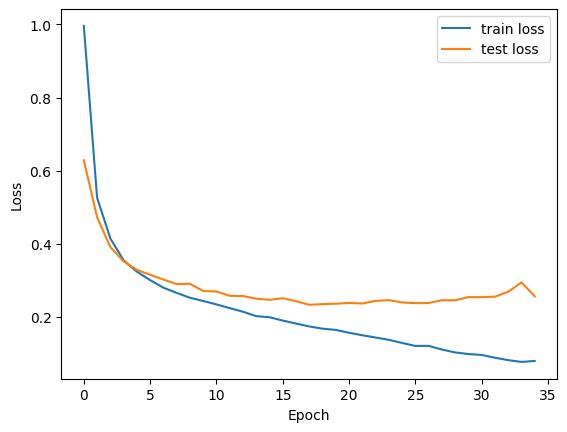

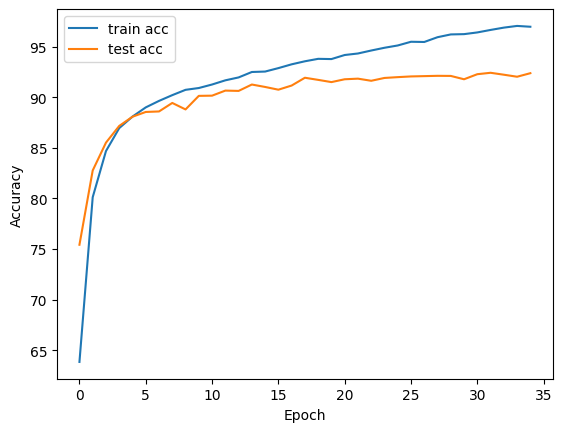

In [14]:
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据增强
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
training_data = datasets.FashionMNIST(root="./", train=True, download=True, transform=AlexTransform)
test_data = datasets.FashionMNIST(root="./", train=False, download=True, transform=AlexTransform)


# 数据加载器
BATCH_SIZE = 512
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

model = ImprovedCNN().to(device)
print(model)
LEARNING_RATE = 0.001
EPOCHS = 35
optimizer = optim.AdamW(model.parameters())
criterion = F.nll_loss
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_dataloader), epochs=EPOCHS)

# 训练和测试函数
def train(model, train_dataloader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        
        # 前向传播
        output = model(data)
        loss = criterion(output, target)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算损失和准确率
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return train_loss / len(train_dataloader), 100. * correct / total

def test(model, test_dataloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            output = model(data)
            loss = criterion(output, target)

            # 计算损失和准确率
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return test_loss / len(test_dataloader), 100. * correct / total

# 训练模型
def train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion, device):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    best_test_accuracy = 0
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
        test_loss, test_acc = test(model, test_dataloader, criterion, device)
        scheduler.step(test_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            print(f"Best Acc:{best_test_accuracy}")
            torch.save(model.state_dict(), "best_model.pth")


    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(test_loss_list, label='test loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train acc')
    plt.plot(test_acc_list, label='test acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # 保存模型
    torch.save(model.state_dict(), 'model.pth')

    # 加载模型
    model = ImprovedCNN()
    model.load_state_dict(torch.load("best_model.pth"))

train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion, device)


### 使得模型在FashionMNIST数据集上的准确率达到92%以上。(1')